# Data

In [2]:
import os
import io
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd
import csv
import xlsxwriter as xlsx
from openpyxl import Workbook
import string
import re
from datetime import datetime
import rpy2.robjects as ro
import rpy2.robjects.numpy2ri
import seaborn as sns
from sklearn import svm
%matplotlib inline
from scipy import stats
import re
from scipy.signal import butter, lfilter
import sys

### Folder

In [3]:
main = "/Users/danie/Desktop/Data" 

### T1 Baseline ###
workT1 = '000. T1 Baseline test/Test_axial_load_*.txt'
T1 = glob.glob(os.path.join(main, workT1))

### T2 Baseline ###
workT2 = '001. T2 Baseline no shaker/20190418 BaselineTest_*.txt'
T2 = glob.glob(os.path.join(main, workT2))

### T3 Inner_ring (400mm) ###
workT3 = '002. T3 Inner ring damage no shaker/20190424 IR_Damage_*.txt'
T3 = glob.glob(os.path.join(main, workT3))

### T5 Inner_ring (100mm) ###
workT5 = '005. T5 Inner ring damage/20190718 - T5 IR damage SN17-12620_Rep_*.txt'
T5 = glob.glob(os.path.join(main, workT5))

### T9 Outer_ring (400mm) ###
workT9 = '011. T9 OR Damage FAG/20190826 - T9 Outer Ring Dmg  SN17-12628 - FAG_DAQ_*.txt'
T9 = glob.glob(os.path.join(main, workT9))

### T10 Outer_ring (200mm) ###
workT10 = '013. T10 OR Damage FAG/20190829 - T10 Outer Ring Dmg  S`N17-12626 - FAG_DAQ_*.txt'
T10 = glob.glob(os.path.join(main, workT10))

### T11 Outer_ring (100mm) ###
workT11 = '015. T11 OR Damage FAG/20190903 - T11 Outer Ring Dmg  SN17-12625 - FAG_DAQ_*.txt'
T11 = glob.glob(os.path.join(main, workT11))

### T12 Ball (400mm) ###
workT12 = '017. T12 Ball Damage FAG/20190911 - T12 Ball Dmg  SN17-12624 - FAG_DAQ_*.txt'
T12 = glob.glob(os.path.join(main, workT12))

### T13 Ball (100mm) ###
workT13 = '019. T13 Ball Damage FAG/20190916 - T13 Ball Dmg  SN17-12629 - FAG_DAQ_*.txt'
T13 = glob.glob(os.path.join(main, workT13))

### T14 Slippage ###
workT14 = '022. T14 Slippage FAG rep/20191010 - T14 Slippage SN17-12619 - FAG_DAQ_decreasing load - Rep_*.txt'
T14 = glob.glob(os.path.join(main, workT14))

### T15 Ball (mm) ###
workT15 = '023. T15 Ball Damage FAG/20191021 - T15 Ball Dmg  SN17-12627 - FAG_DAQ_*.txt'
T15 = glob.glob(os.path.join(main, workT15))

In [4]:
### T9 REP Outer_ring (400mm) ###
workT9rep = '012. T9 OR Damage FAG rep/20190827 - T9 Outer Ring Dmg  SN17-12628 - FAG_DAQ - Rep_*.txt'
T9rep = glob.glob(os.path.join(main, workT9rep))

### T10 REP Outer_ring (200mm) ###
workT10rep = '014. T10 OR Damage FAG rep/20190830 - T10 Outer Ring Dmg  SN17-12626 - FAG_DAQ - Rep_*.txt'
T10rep = glob.glob(os.path.join(main, workT10rep))

### T11 REP Outer_ring (100mm) ###
workT11rep = '016. T11 OR Damage FAG rep/20190904 - T11 Outer Ring Dmg  SN17-12625 - FAG_DAQ - Rep_*.txt'
T11rep = glob.glob(os.path.join(main, workT11rep))

### T12 REP Ball (400mm) ###
workT12rep = '018. T12 Ball Damage FAG rep/20190912 - T12 Ball Dmg  SN17-12624 - FAG_DAQ - Rep_*.txt'
T12rep = glob.glob(os.path.join(main, workT12rep))

### T13 REP Ball (100mm) ###
workT13rep = '020. T13 Ball Damage FAG rep/20190917 - T13 Ball Dmg  SN17-12629 - FAG_DAQ - Rep_*.txt'
T13rep = glob.glob(os.path.join(main, workT13rep))

### T15 REP Ball (100mm) ###
workT15rep = '024. T15 Ball Damage FAG rep/20191022 - T15 Ball Dmg  SN17-12627 - FAG_DAQ - Rep_*.txt'
T15rep = glob.glob(os.path.join(main, workT15rep))

### R function

In [5]:
ro.numpy2ri.activate()
ro.r('''source('/Users/danie/Desktop/Data/R functions.R')''')
r_rpm = ro.globalenv['Tachometer.speed']
r_reduction = ro.globalenv['Sample.reduction']

In [6]:
# converting a list into a tuple(to be able to run in Matplotlib)
def convert(RRR):
    return tuple(RRR)

### Time 

In [7]:
########## Time Interval (Seconds) ##########

### Creating a interval time in SECONDS using data from one folder ###
def time_delta(timedelta):
    number = 0
    time1_arrays = []
    for path in timedelta:
        number += 1
        with io.open(path, mode = 'r') as fd:
            # Using time from the "Start time"
            time_reader = pd.read_csv(fd, nrows = 0, skiprows = 2, delimiter = ("\t"))
            for sentence in time_reader:
                # Remove all the punctuation
                remove = string.punctuation
                # Replace "," with "Space"
                remove = remove.replace(",","")
                pattern = r"[{}]".format(remove)
                test_time = re.sub(pattern," ", str(sentence))
                splitted_time = str(test_time).split(' ')
                # Choose the time only, exclude the date
                time_split = splitted_time[6:9]
                time1 = time_split[0]+":"+time_split[1]+":"+time_split[2]
                # Putting into "hour:mins:sec" format
                FMT = '%H:%M:%S'
                if number == 1:
                    # Set the start time as the first time 
                    int_time = time1
                    # Insert 0 seconds for the first file
                    time1_arrays.append(0)
                else:
                    # Subtracting the current time with the initial time to obtain the time difference 
                    tdelta = datetime.strptime(time1, FMT) - datetime.strptime(int_time, FMT)
                    # Change the time format to seconds
                    tdelta = tdelta.total_seconds() 
                    time1_arrays.append(tdelta)
    return time1_arrays

In [8]:
# Average 100000 points by 2000. Hence getting 50 points.
def average(array):
    empty_array = []
    for i in range(1):
        x = 0
        y = 2001
        for j in range(50):
            #averaging every 2000 points
            points = array.iloc[x:y].mean(axis=0)
            empty_array.append(points)
            x = x + 2000
            y = y + 2000
            # 50 points in the final
    return empty_array

In [9]:
########## Time DataFrame (Seconds) ##########

### Creating TIME DataFrame with the interval time(seconds) for one folder ###
def time_df(seconds_delta):
    timedf = pd.DataFrame()
    for no_time in range(len(seconds_delta)):
        # Create a series of 100000 
        time = pd.Series(range(100000))
        # Divide by 100000 to get the decimal points of all 100000points
        time = time.div(100000, axis = 0)
        # Average all 100000 decimal points to 50 points at the end
        time_ave = average(time) 
        time_ori = pd.DataFrame(time_ave, columns = ['Time'])
        # Add the decimals to the seconds obtain from "time_delta"
        time_domain = time_ori.add(seconds_delta[no_time])
        global timedf1
        timedf = timedf.append(pd.DataFrame(time_domain))
        timedf1 = pd.concat([timedf], ignore_index = True)
    return timedf1

### Load

In [10]:
########## Axial & Radial Load ##########

### DataFrame of Axial Load and Radial Load from each folder ### 
def load(loads):
    load_df = pd.DataFrame()
    for file_load in loads: #reading multiple texts from a folder
        load_arrays = []
        with io.open(file_load, mode = 'r') as ld:
            load_reader = pd.read_csv(ld, delimiter = ("\t"), skiprows = 10, usecols = [13,14])
            load_arrays = average(load_reader)

            AL = [] #Axial_Load
            RL = [] #Radial_Load

            load_split1 = np.array_split(load_arrays, 50, axis = 0) #splitting arrays into multiple arrrays

            #Splitting each variable into it's own list
            for load_a in range(50):
                load_split2 = load_split1[load_a]
                load_split3 = load_split2[0]
                for load_b in range(2):
                    load_split4 = load_split3[load_b]
                    load_split5 = float(load_split4)
                    if load_b == 0:
                        AL.append(load_split5)
                    elif load_b == 1:
                        RL.append(load_split5)

            Axial_load = convert(AL)
            Radial_load= convert(RL)

            load_data = {'Axial_load': Axial_load,
                         'Radial_load': Radial_load,}

            #Append all datas into DataFrame
            global load_df1
            load_df = load_df.append(pd.DataFrame(load_data))
            load_df1 = pd.concat([load_df], ignore_index = True)
    return load_df1

In [11]:
# Split data for Acceleration Vertical and Horizontal

def split(array, no):
    empty_array = []
    # Splitting 1 huge array to 13 seperated arrays
    arr_split = np.array_split(array, 13, axis = 0)
    for x in range(50):
        # 'no' is where it choses the which column to use (mean, sd, rms, crest, skewness, kurtosis) 
        x_split = arr_split[no][0]
        # Choosing each number from 1 column
        x_split1 = x_split[x]
        # Converting each data to float 
        x_split2 = float(x_split1)
        empty_array.append(x_split2)
        convert_x = convert(empty_array)
    return convert_x

### High-Pass Filter

In [12]:
###### Applying High-Pass Filter to Vertical Acceleration for T1, T2 and T3 ######

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, 0.9999999], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

### Acceleration testing

In [20]:
def acce1(acc_hor_ver):
    #Selecting function's name (acc_hor_ver; exp: "T2")
    def namestr(obj, namespace):
        return [name for name in namespace if namespace[name] is obj]
    file = namestr(acc_hor_ver, globals())
    #Splitting "T2" to "T" & "2"
    r = re.compile("([a-zA-Z]+)([0-9]+)")
    fileno = [r.match(string).groups() for string in file]
    #Selecting the integer from the function (exp: "2")
    file_no = int(fileno[0][1])
    acc_df = pd.DataFrame()
    for file_acc in acc_hor_ver:
        with io.open(file_acc, mode = 'r') as acc:
            acc_reader = pd.read_csv(acc, delimiter = ("\t"), skiprows = 10, usecols = [0,7,8])
            acc_hor_reader = acc_reader['Acc_horizontal (g)']
            acc_ver_reader = acc_reader['Acc_vertical (g)']

            #Scaling factor
            if file_no >= 1 and file_no <= 4:
                #Filtering for Acc_Vertical between 500 to 50000Hz
                acc_ver_fil = butter_bandpass_filter(acc_ver_reader, 500, 50000, 100000)
                #Removing first and last 200 points of signal (Affected signals)
                acc_ver_filter = acc_ver_fil[200:99800]
                acc_ver_df = pd.DataFrame(acc_ver_filter)
                acc_ver_mean = acc_ver_df.iloc[0:100000].mean(axis=0)
                acc_ver_finalarray = acc_ver_filter - acc_ver_mean[0]
                acc_ver_final = pd.Series(acc_ver_finalarray)
            #for T5 and the rest
            else:
                acc_ver_mean = acc_ver_reader.iloc[0:100000].mean(axis=0)
                acc_ver_final = acc_ver_reader - acc_ver_mean
                
            acc_hor_mean = acc_hor_reader.iloc[0:100000].mean(axis=0)
            acc_hor_final = acc_hor_reader - acc_hor_mean
            

            acc_r_reader = pd.concat([acc_reader['Time (s)'], 
                                      acc_hor_final, 
                                      acc_ver_final], axis=1)
            
            # Applying different parameters for Acceleration Vertical and Horizontal
            reduction = r_reduction(acc_r_reader.values, sample_reduce = 2000, 
                                    apply_filter = False, sampling_rate = 100000, 
                                    R_n = 1,  R_from = 1, R_to = 50000, include_time = True)
            
            hor_mean = split(reduction, 1)
            ver_mean = split(reduction, 2)

            acc_data = {'Acc_Hor (Mean)': hor_mean,
                        'Acc_Ver (Mean)': ver_mean}
            
            global acc_df1
            acc_df = acc_df.append(pd.DataFrame(ver_mean))
            acc_df1 = pd.concat([acc_df], ignore_index = True)
    return acc_df1

In [14]:
timeT1 = time_df(time_delta(T1)) 

In [23]:
accT1 = acce1(T1)
accT2 = acce1(T2)
accT3 = acce1(T3)
accT5 = acce1(T5)
accT9 = acce1(T9)
accT10 = acce1(T10)
accT11 = acce1(T11)
accT12 = acce1(T12)
accT13 = acce1(T13)
accT15 = acce1(T15)

In [35]:
acc = accT1, accT2, accT3, accT5, accT9, accT10, accT11, accT12, accT13, accT15
acc.to_excel("rep.xlsx")

AttributeError: 'tuple' object has no attribute 'to_excel'

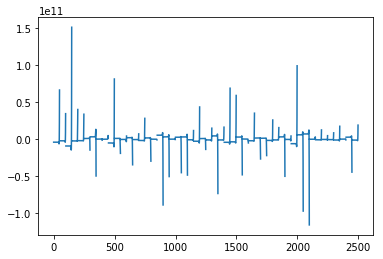

In [47]:
plt.plot(accT1)
plt.savefig('T1')

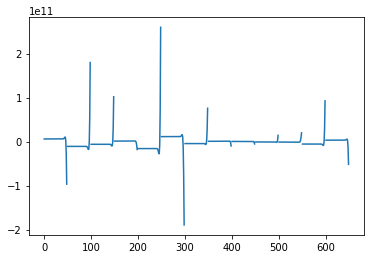

In [48]:
plt.plot(accT2)
plt.savefig('T2')

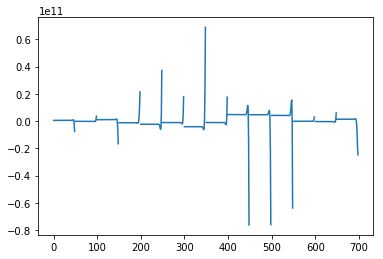

In [49]:
plt.plot(accT3)
plt.savefig('T3')

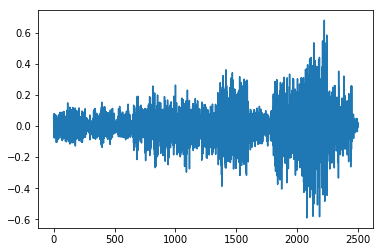

In [50]:
plt.plot(accT5)
plt.savefig('T5')

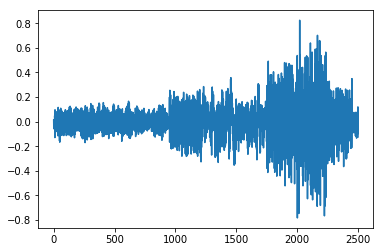

In [51]:
plt.plot(accT9)
plt.savefig('T9')

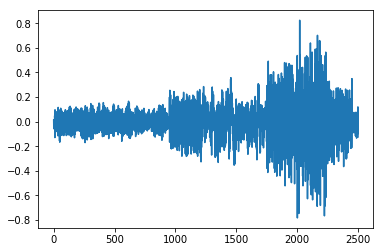

In [52]:
plt.plot(accT10)
plt.savefig('T10')

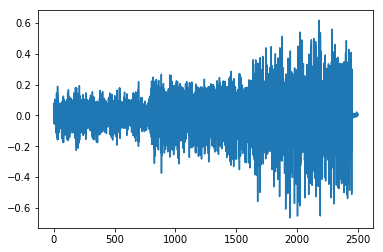

In [53]:
plt.plot(accT11)
plt.savefig('T11')

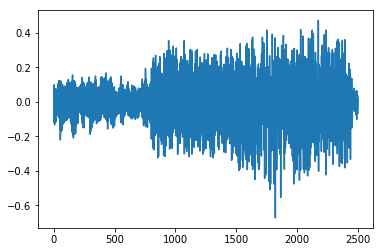

In [54]:
plt.plot(accT12)
plt.savefig('T12')

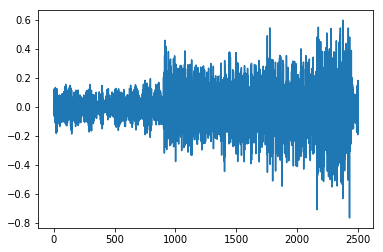

In [55]:
plt.plot(accT13)
plt.savefig('T13')

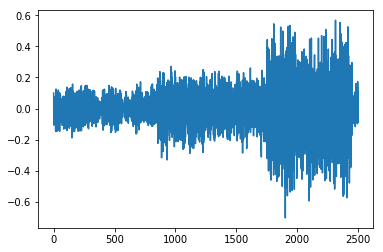

In [56]:
plt.plot(accT15)
plt.savefig('T15')

### Vertical & Horizontal Acceleration 

In [32]:
########## Accelerometer Hor & Ver ##########

### Scaling vibration signals before averaging data for by the 3 variables ###
def acce1(acc_hor_ver):
    #Selecting function's name (acc_hor_ver; exp: "T2")
    def namestr(obj, namespace):
        return [name for name in namespace if namespace[name] is obj]
    file = namestr(acc_hor_ver, globals())
    #Splitting "T2" to "T" & "2"
    r = re.compile("([a-zA-Z]+)([0-9]+)")
    fileno = [r.match(string).groups() for string in file]
    #Selecting the integer from the function (exp: "2")
    file_no = int(fileno[0][1])
    acc_df = pd.DataFrame()
    for file_acc in acc_hor_ver:
        with io.open(file_acc, mode = 'r') as acc:
            acc_reader = pd.read_csv(acc, delimiter = ("\t"), skiprows = 10, usecols = [0,7,8])
            acc_hor_reader = acc_reader['Acc_horizontal (g)']
            acc_ver_reader = acc_reader['Acc_vertical (g)']

            '''
            # Subtraction of mean of all the points is to remove offset by getting the mean of all 100000 points 
            # Subtract all points by the mean obtain
            reader1 = acc_reader.iloc[0:100000].mean(axis=0)
            acc_hor_reader1 = acc_hor_reader - reader1[1]
            acc_ver_reader1 = acc_ver_reader - reader1[2]
            '''
            #Scaling factor
            if file_no >= 1 and file_no <= 4:
                #Filtering for Acc_Vertical between 500 to 50000Hz
                acc_ver_fil = butter_bandpass_filter(acc_ver_reader, 500, 50000, 100000)
                #Removing first and last 200 points of signal (Affected signals)
                acc_ver_filter = acc_ver_fil[200:99800]
                #for T1
                if file_no == 1:
                    acc_hor_scale = acc_hor_reader*(245*4000/2.454)
                    acc_ver_scale = acc_ver_filter*(236*400/2.366)
                #for T2, T3 and T4
                else:
                    acc_hor_scale = acc_hor_reader*(245*20/2.454)
                    acc_ver_scale = acc_ver_filter*(236*250/2.366)
                acc_ver_df = pd.DataFrame(acc_ver_scale)
                acc_ver_mean = acc_ver_df.iloc[0:100000].mean(axis=0)
                acc_ver_finalarray = acc_ver_scale - acc_ver_mean[0]
                acc_ver_final = pd.Series(acc_ver_finalarray)
            #for T5 and the rest
            else:
                acc_hor_scale = acc_hor_reader*(145/2.454)
                acc_ver_scale = acc_ver_reader*(190/2.366)
                acc_ver_mean = acc_ver_scale.iloc[0:100000].mean(axis=0)
                acc_ver_final = acc_ver_scale - acc_ver_mean
                
            acc_hor_mean = acc_hor_scale.iloc[0:100000].mean(axis=0)
            acc_hor_final = acc_hor_scale - acc_hor_mean
            

            acc_r_reader = pd.concat([acc_reader['Time (s)'], 
                                      acc_hor_final, 
                                      acc_ver_final], axis=1)
            
            # Applying different parameters for Acceleration Vertical and Horizontal
            reduction = r_reduction(acc_r_reader.values, sample_reduce = 2000, 
                                    apply_filter = False, sampling_rate = 100000, 
                                    R_n = 1,  R_from = 1, R_to = 50000, include_time = True)
            
            hor_mean = split(reduction, 1)
            ver_mean = split(reduction, 2)
            hor_rms = split(reduction, 3)
            ver_rms = split(reduction, 4)
            hor_sd = split(reduction, 5)
            ver_sd = split(reduction, 6)
            hor_crest = split(reduction, 7)
            ver_crest = split(reduction, 8)
            hor_skewness = split(reduction, 9)
            ver_skewness = split(reduction, 10)
            hor_kurtosis = split(reduction, 11)
            ver_kurtosis = split(reduction, 12)

            acc_data = {'Acc_Hor (Mean)': hor_mean,
                        'Acc_Ver (Mean)': ver_mean,
                        'Acc_Hor (RMS)': hor_rms,
                        'Acc_Ver (RMS)': ver_rms,
                        'Acc_Hor (SD)': hor_sd,
                        'Acc_Ver (SD)': ver_sd,
                        'Acc_Hor (Crest)': hor_crest,
                        'Acc_Ver (Crest)': ver_crest,
                        'Acc_Hor (Skewness)': hor_skewness,
                        'Acc_Ver (Skewness)': ver_skewness,
                        'Acc_Hor (Kurtosis)': hor_kurtosis,
                        'Acc_Ver (Kurtosis)': ver_kurtosis}
            
            global acc_df1
            acc_df = acc_df.append(pd.DataFrame(ver_mean))
            acc_df1 = pd.concat([acc_df], ignore_index = True)
    return acc_df1

### Shaft Speed

In [18]:
########## Tachometer Speed ##########

def tacho_s(tacho_speed):
    ts_df1 = pd.DataFrame()
    ts_df = pd.DataFrame()
    ts_arrays = []
    for tacho_file in tacho_speed:
        with io.open(tacho_file, mode = 'r') as ts:  
            ts_reader = pd.read_csv(ts, delimiter = ("\t"), skiprows = 10, usecols = [16])
            # Running R function to convert value to RPM
            tacho_speeds = r_rpm(Data_input = ts_reader.values, Min_trigger = 3, Max_trigger = 4, Range_accept = 2, 
                                 Min_accept = 4, Tachometer_pulse = 6, Sampling_rate = 100000, Checks = False, 
                                 Show_plot = False, Reforming = False,R_From = 1, R_To = 5000, R_Multi = 1)
            ts_arrays.append(tacho_speeds[0])
    for tarrays_no in range(len(ts_arrays)):
        for rows in range(50):
            ts_df1.loc[rows, 'Shaft_speed'] = ts_arrays[tarrays_no]
        global ts_dfmain
        ts_df = ts_df.append(pd.DataFrame(ts_df1))
        ts_dfmain = pd.concat([ts_df], ignore_index = True)
    return ts_dfmain

In [22]:
timeT1 = time_df(time_delta(T1)) 
timeT2 = time_df(time_delta(T2))
timeT3 = time_df(time_delta(T3))
timeT5 = time_df(time_delta(T5))
timeT9 = time_df(time_delta(T9))
timeT10 = time_df(time_delta(T10))
timeT11 = time_df(time_delta(T11))
timeT12 = time_df(time_delta(T12))
timeT13 = time_df(time_delta(T13))
#timeT14 = time_df(time_delta(T14))
timeT15 = time_df(time_delta(T15))
time = timeT1, timeT2, timeT3, timeT5, timeT9, timeT10, timeT11, timeT12, timeT13, timeT15

In [23]:
loadT1 = load(T1)
loadT2 = load(T2)
loadT3 = load(T3)
loadT5 = load(T5)
loadT9 = load(T9)
loadT10 = load(T10)
loadT11 = load(T11)
loadT12 = load(T12)
loadT13 = load(T13)
#loadT14 = load(T14)
loadT15 = load(T15)
loads = loadT1, loadT2, loadT3, loadT5, loadT9, loadT10, loadT11, loadT12, loadT13, loadT15

In [24]:
accT1 = acce(T1)
accT2 = acce(T2)
accT3 = acce(T3)
accT5 = acce(T5)
accT9 = acce(T9)
accT10 = acce(T10)
accT11 = acce(T11)
accT12 = acce(T12)
accT13 = acce(T13)
#accT14 = acc2(T14)
accT15 = acce(T15)
acc = accT1, accT2, accT3, accT5, accT9, accT10, accT11, accT12, accT13, accT15

In [25]:
tachoT1 = tacho_s(T1)
tachoT2 = tacho_s(T2)
tachoT3 = tacho_s(T3)
tachoT5 = tacho_s(T5)
tachoT9 = tacho_s(T9)
tachoT10 = tacho_s(T10)
tachoT11 = tacho_s(T11)
tachoT12 = tacho_s(T12)
tachoT13 = tacho_s(T13)
#tachoT14 = tacho_s(T14)
tachoT15 = tacho_s(T15)
tacho = tachoT1, tachoT2, tachoT3, tachoT5, tachoT9, tachoT10, tachoT11, tachoT12, tachoT13, tachoT15

In [26]:
timeT9rep = time_df(time_delta(T9rep))
timeT10rep = time_df(time_delta(T10rep))
timeT11rep = time_df(time_delta(T11rep))
timeT12rep = time_df(time_delta(T12rep))
timeT13rep = time_df(time_delta(T13rep))
timeT15rep = time_df(time_delta(T15rep))
timerep = timeT9rep, timeT10rep, timeT11rep, timeT12rep, timeT13rep, timeT15rep

In [18]:
loadT9rep = load(T9rep)
loadT10rep = load(T10rep)
loadT11rep = load(T11rep)
loadT12rep = load(T12rep)
loadT13rep = load(T13rep)
loadT15rep = load(T15rep)
loadrep = loadT9rep, loadT10rep, loadT11rep, loadT12rep, loadT13rep, loadT15rep

In [19]:
accT9rep = acce(T9rep)
accT10rep = acce(T10rep)
accT11rep = acce(T11rep)
accT12rep = acce(T12rep)
accT13rep = acce(T13rep)
accT15rep = acce(T15rep)
accrep = accT9rep, accT10rep, accT11rep, accT12rep, accT13rep, accT15rep

In [20]:
tachoT9rep = tacho_s(T9rep)
tachoT10rep = tacho_s(T10rep)
tachoT11rep = tacho_s(T11rep)
tachoT12rep = tacho_s(T12rep)
tachoT13rep = tacho_s(T13rep)
tachoT15rep = tacho_s(T15rep)
tachorep = tachoT9rep, tachoT10rep, tachoT11rep, tachoT12rep, tachoT13rep, tachoT15rep

In [19]:
main_df_1 = pd.DataFrame()
type_0 = np.zeros([])
#rep_df = pd.DataFrame()
rep_df = pd.concat([timeT9rep1, accT9rep1, loadT9rep1, tachoT9rep1], axis = 1)
rep_df.insert(0, "Type", type_0, True)
main_df_1 = main_df_1.append(rep_df)
main_df = pd.concat([main_df_1], ignore_index = True, sort = True)
main_df = main_df[['Type', 'Time', 
                   'Acc_Hor (Mean)', 'Acc_Ver (Mean)',
                   'Acc_Hor (RMS)', 'Acc_Ver (RMS)',
                   'Acc_Hor (SD)', 'Acc_Ver (SD)',
                   'Acc_Hor (Crest)', 'Acc_Ver (Crest)',
                   'Acc_Hor (Skewness)', 'Acc_Ver (Skewness)',
                   'Acc_Hor (Kurtosis)', 'Acc_Ver (Kurtosis)',
                   'Axial_load', 'Radial_load', 'Shaft_speed']]
main_df.to_excel("rep.xlsx")

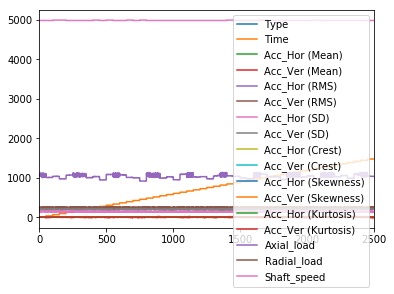

In [20]:
main_df.plot()

In [164]:
### Seperating files and types ###

type0 = np.zeros([])
type1 = np.zeros([]) + 1
type2 = np.zeros([]) + 2
type3 = np.zeros([]) + 3
no4 = np.zeros([]) + 4
no5 = np.zeros([]) + 5
no6 = np.zeros([]) + 6
no7 = np.zeros([]) + 7
no8 = np.zeros([]) + 8
no9 = np.zeros([]) + 9
no10 = np.zeros([]) + 10
main_df1 = pd.DataFrame()
for i in range(len(time)):
    df = pd.concat([time[i], acc[i], loads[i], tacho[i]], axis = 1)
    if i == 0: #T1
        df.insert(0, "Type", type0, True)
        df.insert(0, "File", type1, True)
    elif i == 1: #T2
        df.insert(0, "Type", type0, True)
        df.insert(0, "File", type2, True)
    elif i == 2: #T3
        df.insert(0, "Type", type1, True)
        df.insert(0, "File", type3, True)
    elif i == 3: #T5
        df.insert(0, "Type", type1, True)
        df.insert(0, "File", no4, True)
    elif i == 4: #T9
        df.insert(0, "Type", type2, True)
        df.insert(0, "File", no5, True)
    elif i == 5: #T10
        df.insert(0, "Type", type2, True)
        df.insert(0, "File", no6, True)
    elif i == 6: #T11
        df.insert(0, "Type", type2, True)
        df.insert(0, "File", no7, True)
    elif i == 7: #T12
        df.insert(0, "Type", type3, True)
        df.insert(0, "File", no8, True)
    elif i == 8: #T13
        df.insert(0, "Type", type3, True)
        df.insert(0, "File", no9, True)
    elif i == 9: #T15
        df.insert(0, "Type", type3, True)
        df.insert(0, "File", no10, True)
    main_df1 = main_df1.append(df)
    main_df = pd.concat([main_df1], ignore_index = True, sort = True)
main_df = main_df[['File', 'Type', 'Time', 
                   'Acc_Hor (Mean)', 'Acc_Ver (Mean)',
                   'Acc_Hor (RMS)', 'Acc_Ver (RMS)',
                   'Acc_Hor (SD)', 'Acc_Ver (SD)',
                   'Acc_Hor (Crest)', 'Acc_Ver (Crest)',
                   'Acc_Hor (Skewness)', 'Acc_Ver (Skewness)',
                   'Acc_Hor (Kurtosis)', 'Acc_Ver (Kurtosis)',
                   'Axial_load', 'Radial_load', 'Shaft_speed']]

In [165]:
main_df.to_excel("test.xlsx", index = False)

In [34]:
df1 = main_df.loc[main_df['File'] == 1]
df2 = main_df.loc[main_df['File'] == 2]
df3 = main_df.loc[main_df['File'] == 3]
df4 = main_df.loc[main_df['File'] == 4]
df5 = main_df.loc[main_df['File'] == 5]
df6 = main_df.loc[main_df['File'] == 6]
df7 = main_df.loc[main_df['File'] == 7]
df8 = main_df.loc[main_df['File'] == 8]
df9 = main_df.loc[main_df['File'] == 9]
df10 = main_df.loc[main_df['File'] == 10]

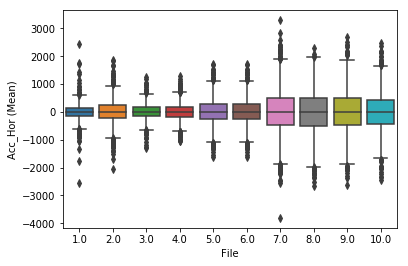

In [161]:
import seaborn as sns
ax = sns.boxplot(x="File", y="Acc_Hor (Mean)", data=main_df)

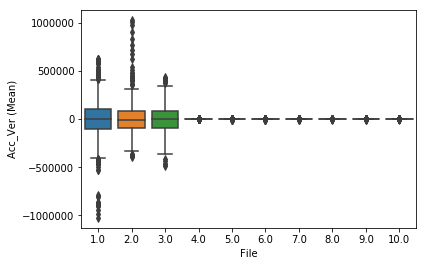

In [162]:
ax = sns.boxplot(x="File", y="Acc_Ver (Mean)", data=main_df)

In [28]:
dfb = pd.concat([df1, df2], axis=0, sort=False)

In [29]:
dfb.to_excel("test2.xlsx", index=False)

In [30]:
dfa = pd.concat([df1, df2], axis=0, sort=False)

In [31]:
dfa.to_excel("test1.xlsx", index=False)

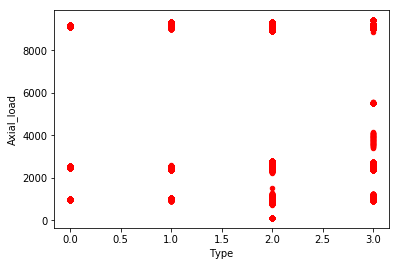

In [21]:
main_df.plot(kind = 'scatter', x = 'Type', y = 'Axial_load', color = 'red')
plt.show()

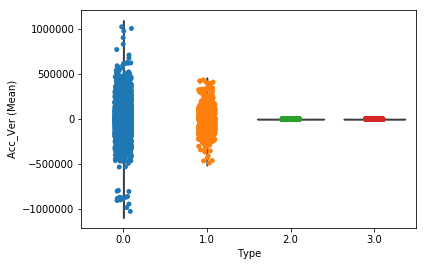

In [163]:
ax = sns.violinplot(x=main_df["Type"], y=main_df["Acc_Ver (Mean)"])
ax = sns.stripplot(x=main_df["Type"], y=main_df["Acc_Ver (Mean)"], jitter = True)

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


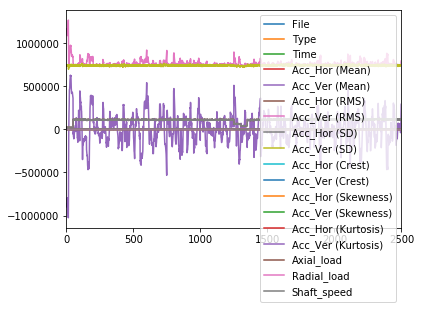

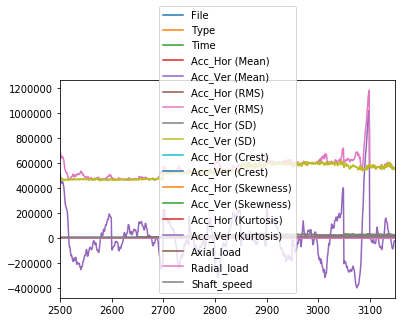

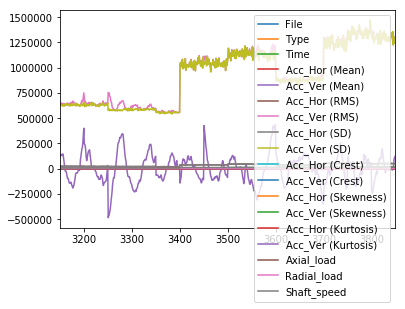

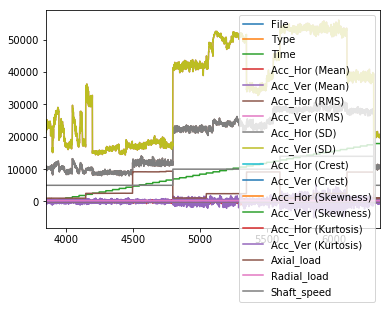

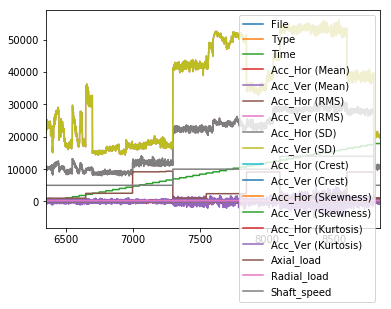

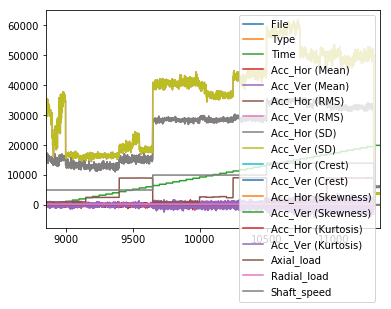

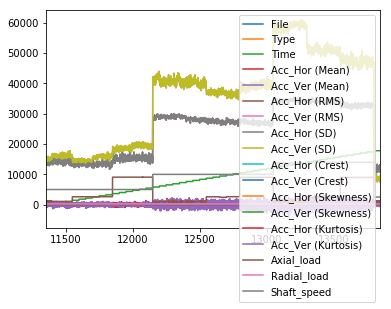

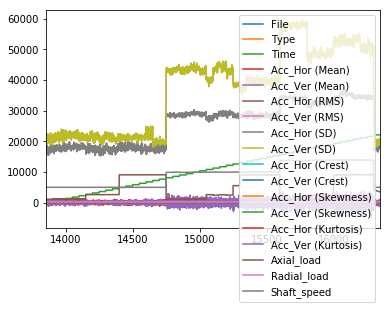

In [25]:
for a in range(1,9):
#print(df1)
    plot = 'df'+'%d' %(a)
    print(eval(plot).plot())
    plt.savefig('df%d.png' %(a))

# USELESS

In [26]:
a.shape
a.head()

,Type,Time,Acc_Hor (Mean),Acc_Ver (Mean),Acc_Hor (RMS),Acc_Ver (RMS),Acc_Hor (SD),Acc_Ver (SD)
3500,1.0,15686.01,7.018620,-45.827795,497.419964,661.645979,497.494835,660.222055
3501,1.0,15686.03,-4.033383,-8.342592,499.346947,684.585474,499.455537,684.705838
3502,1.0,15686.05,-8.613163,5.284241,472.920480,636.144902,472.960294,636.282044
3503,1.0,15686.07,16.734321,-1.080319,474.880142,658.716235,474.703890,658.880090
3504,1.0,15686.09,3.807294,21.069628,492.333699,668.898324,492.442104,668.733610


In [27]:
X = a.drop('Type', axis=1)
y = a['Type']

In [31]:
#from mlxtend.plotting import plot_decision_regions
clf = svm.SVC(decision_function_shape='ovo')
clf.fit(X.values, y.values)
plot_decision_regions(X=X.values, y=y.values, clf=clf, legend=2)
plt.xlabel(X.columns[0], size=14)
plt.ylabel(X.columns[1], size=14)
plt.title('SVM', size=16)

NameError: name 'plot_decision_regions' is not defined

In [2]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

NameError: name 'X' is not defined

In [29]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='linear')
svclassifier.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [30]:
y_pred = svclassifier.predict(X_test)

In [31]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[ 45  22]
 [ 50 483]]
             precision    recall  f1-score   support

        1.0       0.47      0.67      0.56        67
        2.0       0.96      0.91      0.93       533

avg / total       0.90      0.88      0.89       600



In [ ]:
arrays = []
path = "/Users/danie/Desktop/Data/001. T2 Baseline no shaker/20190418 BaselineTest_0033.txt"
with open(path,'r') as f:
    reader = pd.read_csv(f)
    reader.dropna(inplace = True)
    #reader["SG_Outer_L (um/m)"]=reader["SG_Outer_L (um/m)"].str.split("t", n=1, expand=True)
    #print(reader)
    #print(reader)
    #print(reader.iloc[0])
    #for column in range(0,17):
     #   tempoValue = 0
      #  totalValue = 0
       # row_count = 0
        #for row in range(1,100001):
         #       row_count = row_count + 1
          #      tempoValue = (reader.iloc[row][column])
           #     totalValue = float(tempoValue) + float(totalValue)
            #    if row_count == 50:
             #       averageValue = totalValue / row_count
              #      arrays.append(averageValue)
               #     totalValue = 0
                #    row_count = 0

#print(arrays)
#df = pd.DataFrame(arrays[1:], columns=arrays[0])

In [ ]:
file = "/Users/danie/Desktop/Data/001. T2 Baseline no shaker/20190418 BaselineTest_0033.txt" 
with io.open(file, mode = 'r') as path:
    re_reader = pd.read_csv(path, delimiter = ("\t"), skiprows = 10, usecols = [0, 7, 8])
    #print(re_reader)
    reduction = r_reduction(re_reader.values, sample_reduce = 2000, apply_filter = False, sampling_rate = 100000, 
                            R_n = 1,  R_from = 1, R_to = 50000, include_time = True)
print(reduction)

In [ ]:
########## Accelerometer Hor & Ver (OR & BALL) ##########
### Scaling vibration signals before averaging data for "TEST Or+Ball" by the 3 variables ###
def acc2(acc_hor_ver2):
    acc_df = pd.DataFrame()
    for file_acc2 in acc_hor_ver2:
        hor_arrays = []
        ver_arrays = [] 
        with io.open(file_acc2, mode = 'r') as acc:
            acc_reader = pd.read_csv(acc, delimiter = ("\t"), skiprows = 10, usecols = [0,7,8])
            acc_hor_reader = acc_reader['Acc_horizontal (g)']
            acc_ver_reader = acc_reader['Acc_vertical (g)']
            # Subtraction of mean of all the points is to remove offset by getting the mean of all 100000 points 
            # Subtract all points by the mean obtain
            reader1 = acc_reader.iloc[0:100000].mean(axis=0)
            acc_hor_reader1 = acc_hor_reader - reader1[1]
            acc_ver_reader1 = acc_ver_reader - reader1[2]
            # Scaling factor for outer ring and ball damage
            hor_ss = 2.454
            ver_ss = 2.366
            hor_ccf_2 = 1.45
            ver_ccf_2 = 1.9
            scaling_fac = 100
            acc_hor_reader2 = acc_hor_reader1*(scaling_fac*hor_ccf_2/hor_ss)
            acc_ver_reader2 = acc_ver_reader1*(scaling_fac*ver_ccf_2/ver_ss)
            acc_r_reader = pd.concat([acc_reader['Time (s)'], acc_hor_reader2, acc_ver_reader2], axis=1)
            # Applying different parameters for Acceleration Vertical and Horizontal
            reduction = r_reduction(acc_r_reader.values, sample_reduce = 2000, apply_filter = False, sampling_rate = 100000, 
                                    R_n = 1,  R_from = 1, R_to = 50000, include_time = True)
            hor_mean = split(reduction, 1)
            ver_mean = split(reduction, 2)
            hor_rms = split(reduction, 3)
            ver_rms = split(reduction, 4)
            hor_sd = split(reduction, 5)
            ver_sd = split(reduction, 6)
            hor_crest = split(reduction, 7)
            ver_crest = split(reduction, 8)
            hor_skewness = split(reduction, 9)
            ver_skewness = split(reduction, 10)
            hor_kurtosis = split(reduction, 11)
            ver_kurtosis = split(reduction, 12)

            acc_data = {'Acc_Hor (Mean)': hor_mean,
                        'Acc_Ver (Mean)': ver_mean,
                        'Acc_Hor (RMS)': hor_rms,
                        'Acc_Ver (RMS)': ver_rms,
                        'Acc_Hor (SD)': hor_sd,
                        'Acc_Ver (SD)': ver_sd,
                        'Acc_Hor (Crest)': hor_crest,
                        'Acc_Ver (Crest)': ver_crest,
                        'Acc_Hor (Skewness)': hor_skewness,
                        'Acc_Ver (Skewness)': ver_skewness,
                        'Acc_Hor (Kurtosis)': hor_kurtosis,
                        'Acc_Ver (Kurtosis)': ver_kurtosis}
            global acc_df1
            acc_df = acc_df.append(pd.DataFrame(acc_data))
            acc_df1 = pd.concat([acc_df], ignore_index = True)
    return acc_df1

In [ ]:
def acce(acc_hor_ver):
    acc_df = pd.DataFrame()
    for file_acc in acc_hor_ver:
        hor_arrays = []
        ver_arrays = [] 
        with io.open(file_acc, mode = 'r') as acc:
            acc_reader = pd.read_csv(acc, delimiter = ("\t"), skiprows = 10, usecols = [0,7,8])
            acc_hor_reader = acc_reader['Acc_horizontal (g)']
            acc_ver_reader = acc_reader['Acc_vertical (g)']
            acc_r_reader = pd.concat([acc_reader['Time (s)'], acc_hor_reader, acc_ver_reader], axis=1)
            reduction = r_reduction(acc_r_reader.values, sample_reduce = 2000, apply_filter = False, sampling_rate = 100000, 
                        R_n = 1,  R_from = 1, R_to = 50000, include_time = True)
            hor_mean = split(reduction, 1)
            ver_mean = split(reduction, 2)
            global acc_df1
            acc_df = acc_df.append(pd.DataFrame(ver_mean))
            acc_df1 = pd.concat([acc_df], ignore_index = True)
    return acc_df1
